In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve2d

from pyfusion.data import load

In [2]:
SLICE = 70

In [3]:
#type: ignore
def plot(data, title=None):
    """
    Plot the data with optional title and axis labels.
    """
    plt.figure(figsize=(10, 8))
    plt.imshow(data, cmap="gray")
    if title:
        plt.title(title)
    plt.axis("off")
    plt.colorbar()
    plt.show()

In [4]:
FSL = load.load_fsl("../data/example_mri", SLICE)

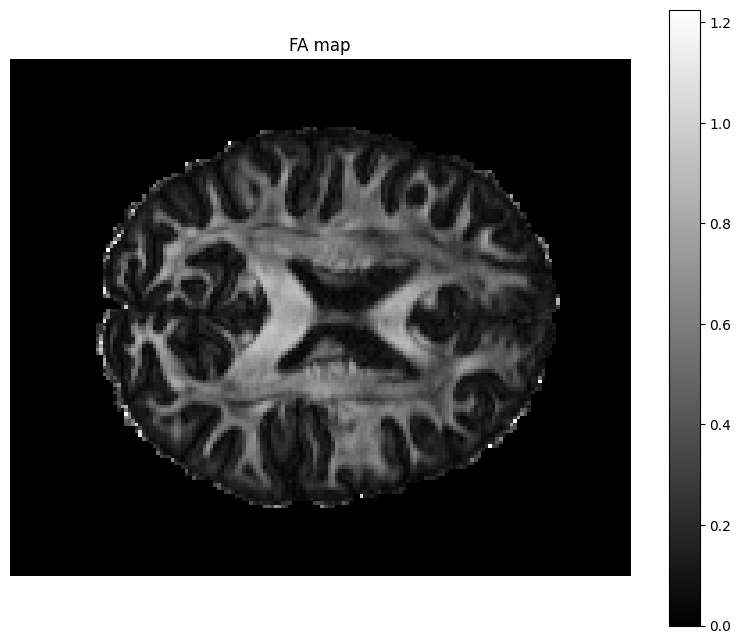

In [5]:
# type: ignore
# Plotting the FA map
plot(FSL.FA, title="FA map")

In [6]:
# add random noise to the FA map
FA_noisy = FSL.FA + 0.2 * FSL.FA.std() * np.random.randn(*FSL.FA.shape)

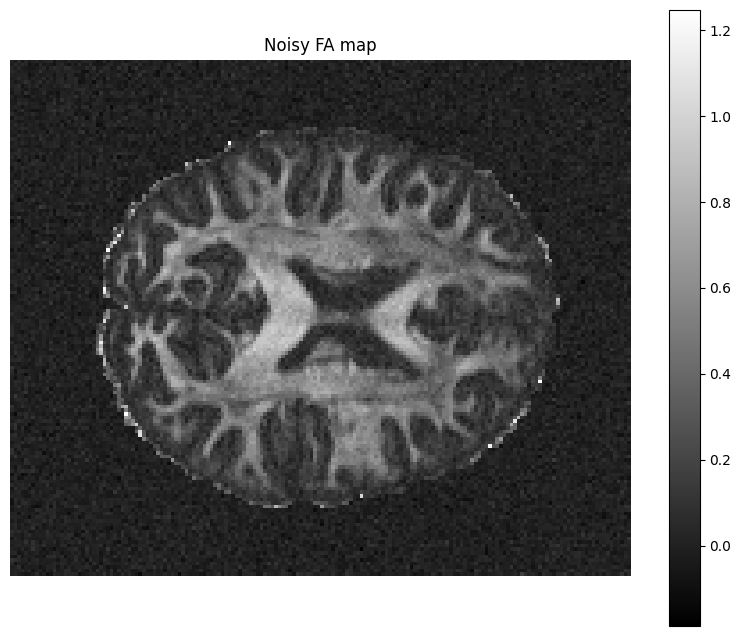

In [7]:
# type: ignore
# Plotting the noisy FA map
plot(FA_noisy, title="Noisy FA map")

In [8]:
def gaussian(std_dev: float, x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Generate a Gaussian kernel.
    """
    return np.exp(-(x**2 + y**2) / (2 * std_dev**2)) / (2 * np.pi * std_dev**2)


def dx_gaussian(std_dev: float, x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Compute the derivative of a Gaussian kernel with respect to x.
    """
    return -x * gaussian(std_dev, x, y) / (std_dev**2)


def dy_gaussian(std_dev: float, x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Compute the derivative of a Gaussian kernel with respect to y.
    """
    return -y * gaussian(std_dev, x, y) / (std_dev**2)

To compute the deriviative of the smoothed image (to get the structure tensor) we compute $\partial_x K_\sigma$ on a quadratic meshgrid, assuming the distance between two cells being 1. The center is considered to be (0|0).

In [9]:
kernel_size = 3

coord = np.linspace(-(kernel_size - 1) / 2, (kernel_size - 1) / 2, kernel_size)
x, y = np.meshgrid(coord, coord)

In [10]:
noise_scale = 0.5   # sigma
integration_scale = 4   # rho

# Create the Gaussian kernels
Gx_noise = dx_gaussian(noise_scale, x, y)   # \partial x K_\sigma
Gy_noise = dy_gaussian(noise_scale, x, y)   # \partial y K_\sigma

G_integration = gaussian(integration_scale, x, y)   # K_\rho

Now we are calculating the structure tensor being
$$\nabla u_\sigma \otimes \nabla u_\sigma = 
\begin{bmatrix}
K_\rho \ast (\partial_x u_\sigma)^2 & K_\rho \ast  \partial_x u_\sigma \cdot \partial_y u_\sigma \\
K_\rho \ast \partial_x u_\sigma \cdot \partial_y u_\sigma & K_\rho \ast (\partial_y u_\sigma)^2
\end{bmatrix}
$$
Using the commutative law of convolution, we calculate the kernel before convoluting.
Using the notation 
$$
=
\begin{bmatrix}
a & b \\
b & c
\end{bmatrix}
$$

In [11]:
K_x = convolve2d(Gx_noise, G_integration, boundary="fill")
K_y = convolve2d(Gy_noise, G_integration, boundary="fill")

In [12]:
a = convolve2d(FA_noisy, K_x, mode="same", boundary="symm")
c = convolve2d(FA_noisy, K_y, mode="same", boundary="symm")
b = a * c

Now we are calculating the the angle of the first eigenvector, and the eigenvalues of each structure tensor (for each point) with
$$
\begin{bmatrix}
\cos \alpha \\
\sin \alpha
\end{bmatrix}
= v_1 \parallel 
\begin{bmatrix}
2b \\
c - a + \sqrt{(a - c)^2 + 4b^2}
\end{bmatrix}
$$
And the corresponding eigenvalues with
$$\mu_{1, 2} = \frac{1}{2}(a+c\pm \sqrt{(a - c)^2 + 4b^2})$$

In [13]:
mu_1 = np.zeros(FA_noisy.shape)
mu_2 = np.zeros(FA_noisy.shape)
alpha_1 = np.zeros(FA_noisy.shape)

discriminant = np.sqrt((a - c) ** 2 + 4 * (b**2))
v = np.stack((2 * b, c - a + discriminant), axis=-1)

alpha_1 = np.arctan2(v[..., 1], v[..., 0])
mu_1 = (a + c + discriminant) / 2
mu_2 = (a + c - discriminant) / 2

Now as we have the eigen decomposition, we apply CED, by setting new eigenvalues
$$
\lambda_1 = \alpha, \lambda_2 =
\begin{cases}
\alpha & \text{, if } \mu_1 = \mu_2 \\
\alpha + (1 - \alpha) \cdot \exp (\frac{-C}{(\mu_1 - \mu_2)^{2m}}) & \text{, else}
\end{cases}
$$

As suggested by Weickert we use $C = 1 = m, \alpha = 0.001$

In [14]:
alpha = 0.001


def lambda_func(mu_1, mu_2):
    """
    Compute the second eigenvalue based on the first eigenvalue and the second mean, if mu_1 and mu_2 are not close.
    """
    return alpha + (1-alpha) * np.exp(-1/(mu_1 - mu_2)**2)


lambda_1 = np.full_like(mu_1, alpha)
lambda_2 = np.zeros_like(mu_2)

mask = np.isclose(mu_1, mu_2)
lambda_2[mask] = alpha
lambda_2[~mask] = lambda_func(mu_1[~mask], mu_2[~mask])

Then according to weickert the entries of the resulting CED-Diffusion Tensor euquals to
$$
D =
\begin{bmatrix}
A & B \\
B & C
\end{bmatrix}
=
\begin{bmatrix}
\lambda_1 \cos^2 \alpha + \lambda_2 \sin^2 \alpha & (\lambda_1 - \lambda_2) \sin \alpha \cos \alpha \\
(\lambda_1 - \lambda_2) \sin \alpha \cos \alpha & \lambda_1 \sin^2 \alpha + \lambda_2 \cos^2 \alpha
\end{bmatrix}
$$

In [15]:
A = lambda_1 * np.cos(alpha_1)**2 + lambda_2 * np.sin(alpha_1)**2
B = (lambda_1 - lambda_2) * np.cos(alpha_1) * np.sin(alpha_1)
C = lambda_1 * np.sin(alpha_1)**2 + lambda_2 * np.cos(alpha_1)**2

Now to compute the final second order diffusion of form (u being the image):
$$\nabla \cdot (D \nabla u) \\
= \partial_x(A \partial_x u + B \partial_y u) + \partial_y (B \partial_x u + C \partial_y u)
$$
For redability purposes we define:
$$
j_1 = A \partial_x u + B \partial_y u \\
j_2 = B \partial_x u + C \partial_y u
$$

We use forward deriviatives, to detect the noise. First we are going to define the deriviative kernels:

In [16]:
D_x = np.array([[-3, 0, 3], [-10, 0, 10], [-3, 0, 3]])  / 32
D_y = np.array([[3, 10, 3], [0, 0, 0], [-3, -10, 3]]) / 32

In [17]:
j_1 = A * convolve2d(FA_noisy, D_x, mode="same", boundary="symm") + B * convolve2d(FA_noisy, D_y, mode="same", boundary="symm")
j_2 = B * convolve2d(FA_noisy, D_x, mode="same", boundary="symm") + C * convolve2d(FA_noisy, D_y, mode="same", boundary="symm")

In [18]:
delta = convolve2d(j_1, D_x, mode="same", boundary="symm") + convolve2d(j_2, D_y, mode="same", boundary="symm")

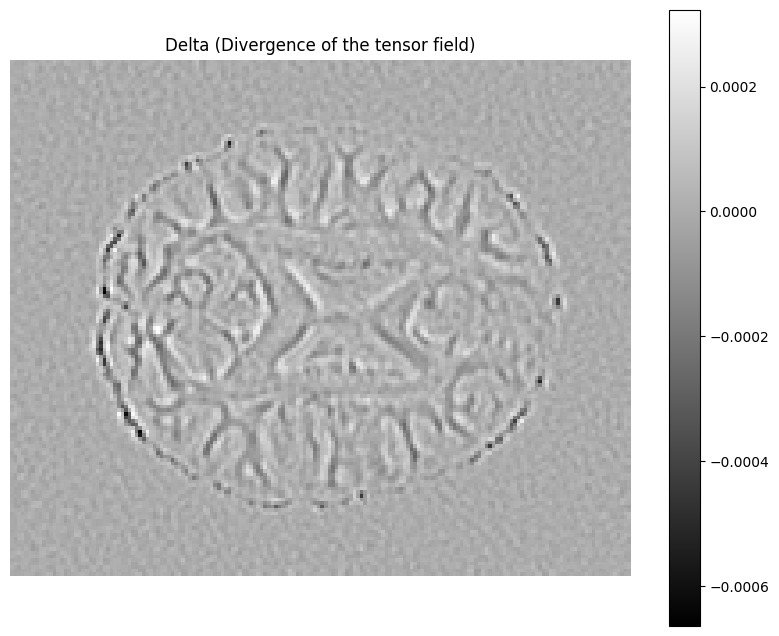

In [19]:
plot(delta, title="Delta (Divergence of the tensor field)")